In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt

In [48]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
ITERATIONS = 15

In [49]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [50]:
class_names = dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites',
 'Target_Spot',
 'Tomato_YellowLeaf__Curl_Virus',
 'Tomato_mosaic_virus']

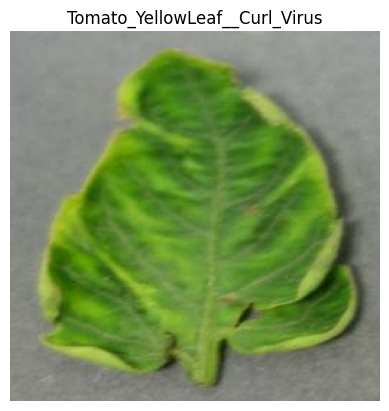

In [51]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [52]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=7)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [53]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [54]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [55]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [56]:
data_augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [57]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_rescale,
    data_augment,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [58]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [59]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    train_ds,
    epochs=ITERATIONS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15


2023-12-22 14:40:00.513755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 343 of 10000
2023-12-22 14:40:05.396654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-12-22 14:40:05.510651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


400/400 [==============================] - ETA: 0s - loss: 1.6081 - accuracy: 0.4280

2023-12-22 14:49:45.266472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 298 of 10000
2023-12-22 14:49:59.325067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-12-22 14:49:59.711400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:100: Filling up shuffle buffer (this may take a while): 1 of 1000
2023-12-22 14:49:59.767425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


400/400 [==============================] - 629s 2s/step - loss: 1.6081 - accuracy: 0.4280 - val_loss: 1.1271 - val_accuracy: 0.6181
Epoch 2/15
400/400 [==============================] - 625s 2s/step - loss: 0.8161 - accuracy: 0.7089 - val_loss: 0.6972 - val_accuracy: 0.7344
Epoch 3/15
400/400 [==============================] - 630s 2s/step - loss: 0.5859 - accuracy: 0.7930 - val_loss: 0.8232 - val_accuracy: 0.7563
Epoch 4/15
400/400 [==============================] - 650s 2s/step - loss: 0.4527 - accuracy: 0.8375 - val_loss: 0.6065 - val_accuracy: 0.7962
Epoch 5/15
400/400 [==============================] - 581s 1s/step - loss: 0.3855 - accuracy: 0.8649 - val_loss: 0.6902 - val_accuracy: 0.7906
Epoch 6/15
400/400 [==============================] - 670s 2s/step - loss: 0.3416 - accuracy: 0.8814 - val_loss: 0.3632 - val_accuracy: 0.8681
Epoch 7/15
400/400 [==============================] - 693s 2s/step - loss: 0.2834 - accuracy: 0.8991 - val_loss: 0.6785 - val_accuracy: 0.7763
Epoch 8/15

Text(0.5, 1.0, 'Training and Validation Accuracy')

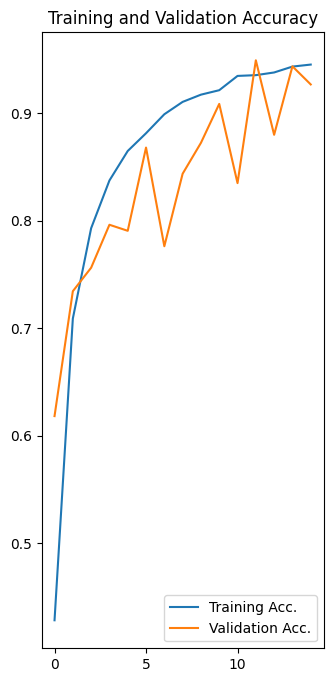

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(ITERATIONS), acc, label ='Training Acc.')
plt.plot(range(ITERATIONS), val_acc, label ='Validation Acc.')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

2023-12-22 17:07:47.963848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 119 of 10000
2023-12-22 17:08:07.978232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 409 of 10000
2023-12-22 17:08:12.765773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-12-22 17:08:13.058591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


image to predict
actual label: Spider_mites
1/1 [==============================] - 1s 926ms/step
predicted label: Spider_mites


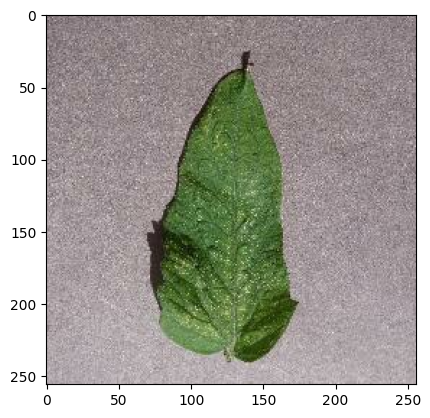

In [62]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [63]:
def predict(model, img):
    imgArray = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    imgArray = tf.expand_dims(imgArray,0)
    
    predictions = model.predict(imgArray)
    predictedClass = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    
    return predictedClass, confidence

1/1 [==============================] - 0s 13ms/step


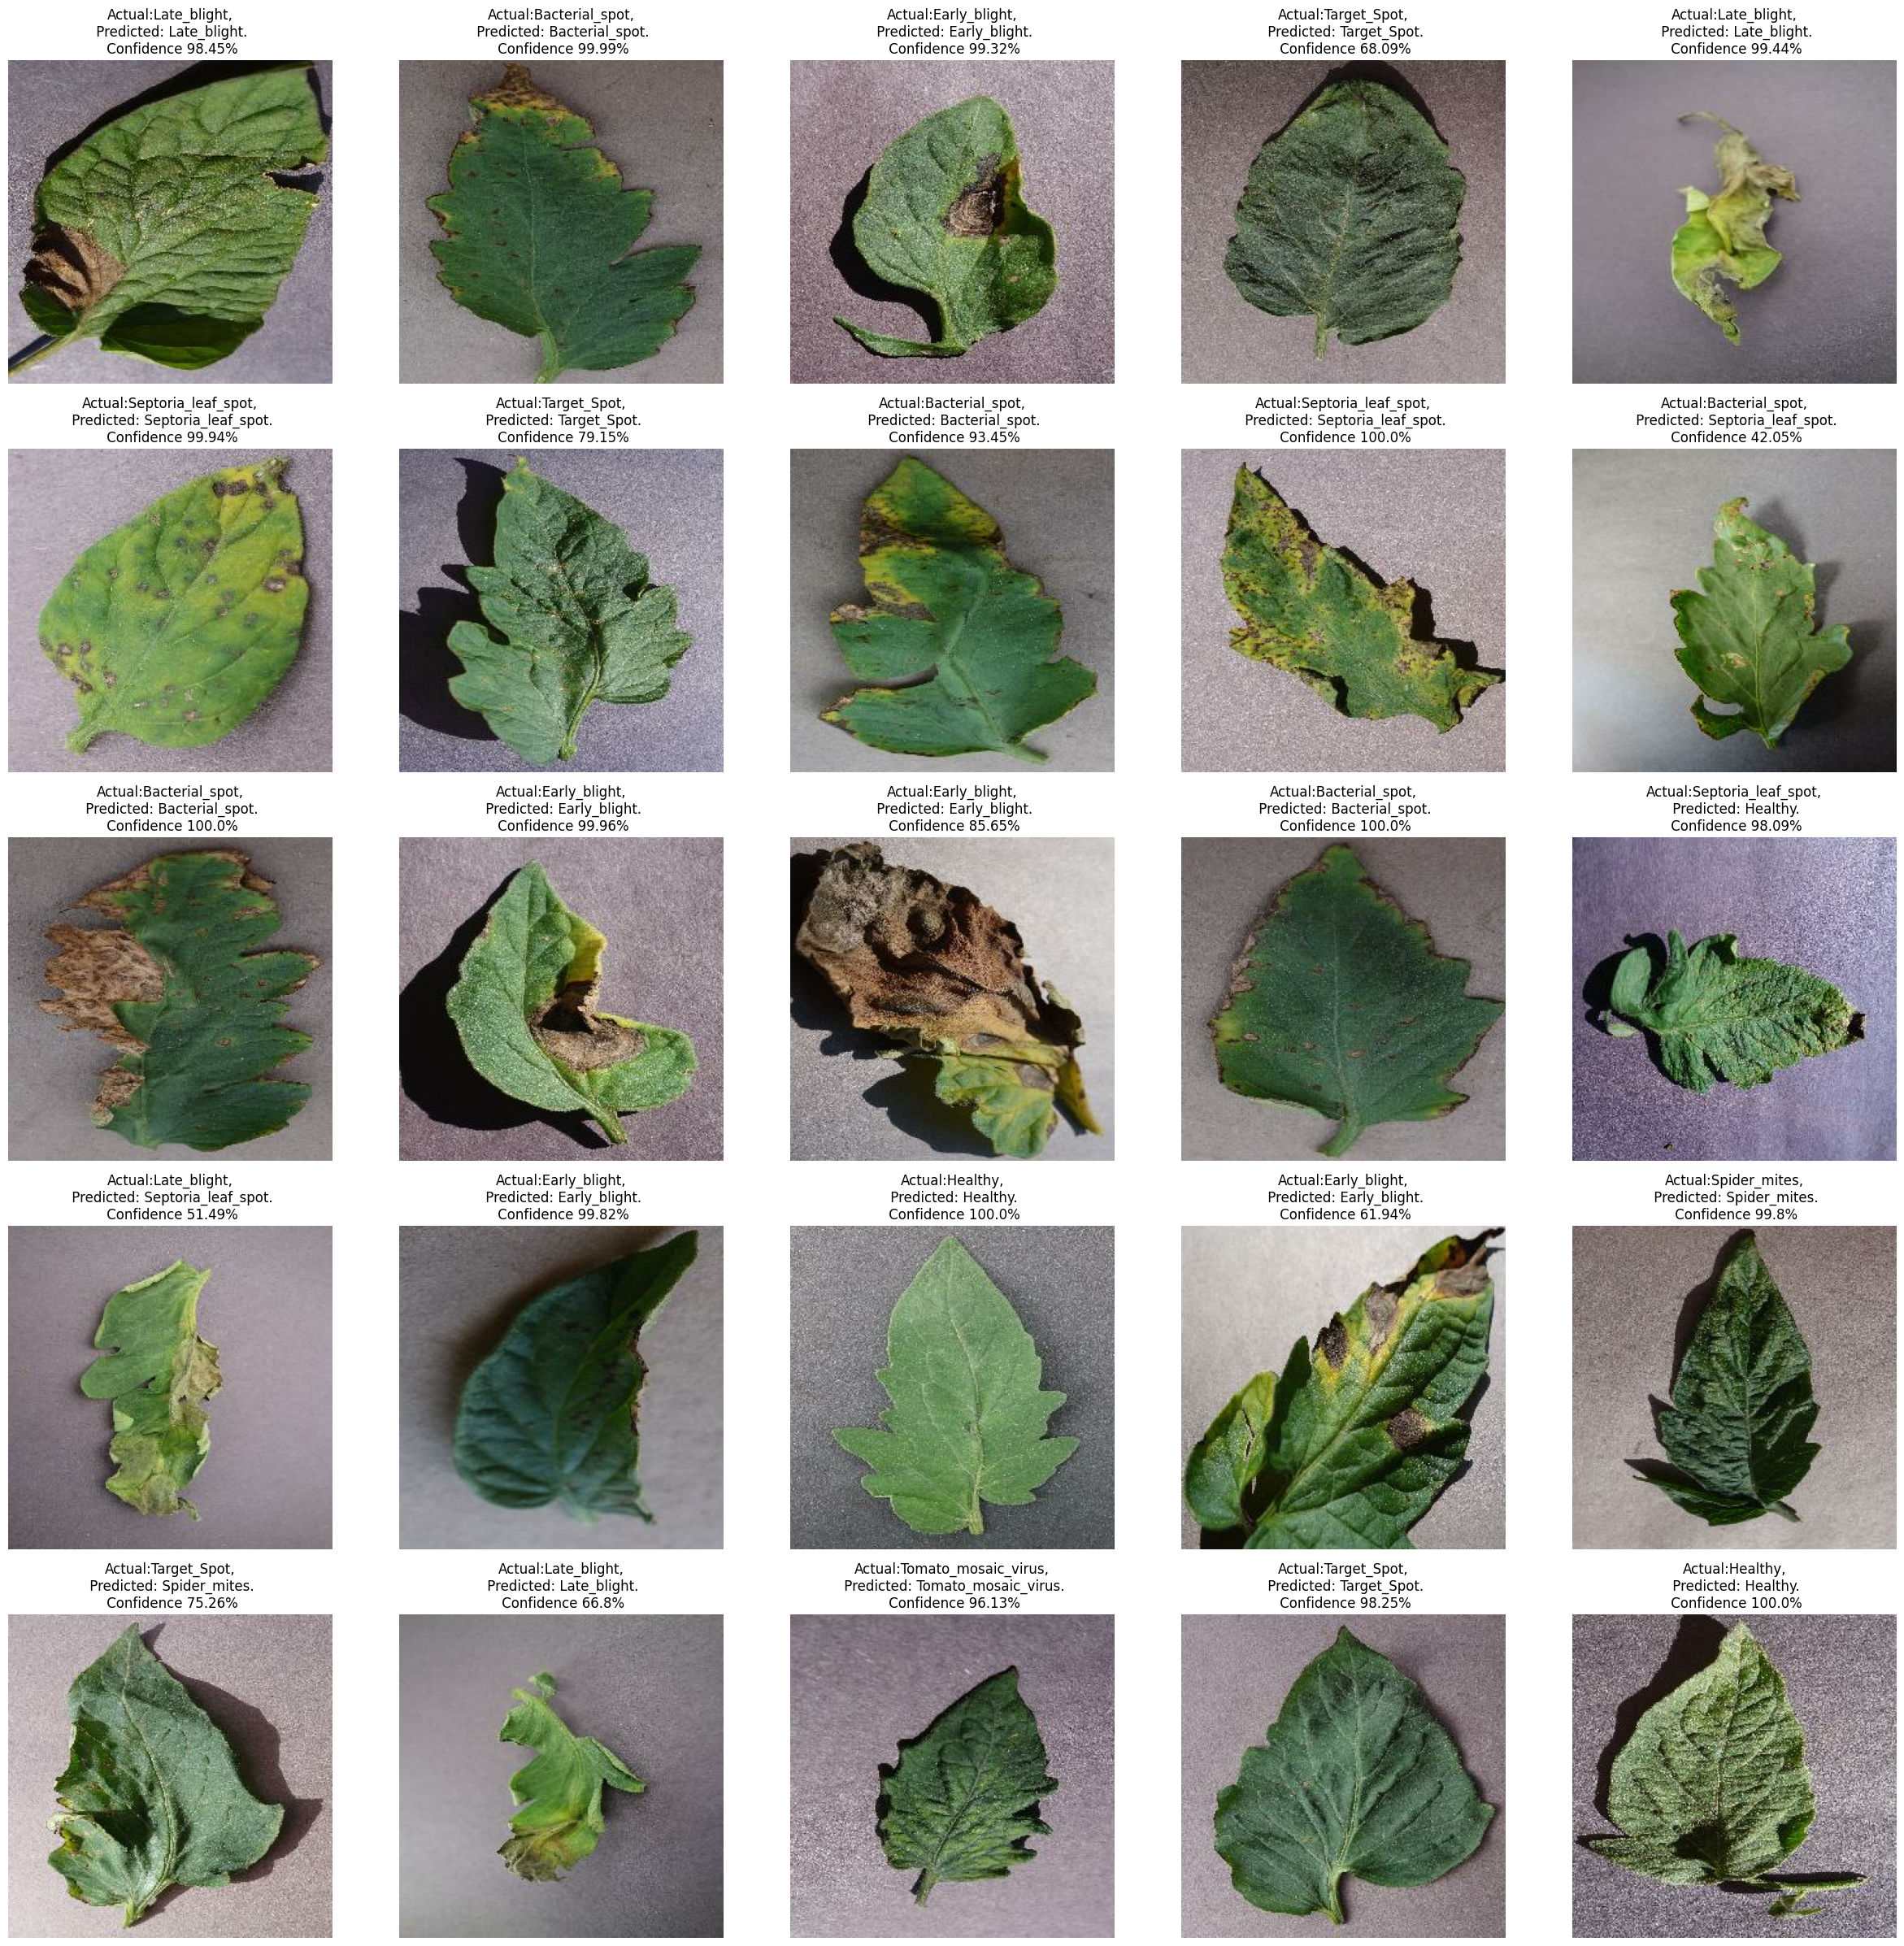

In [65]:
plt.figure(figsize=(30,30))
for images, labels in test_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictedClass, confidence = predict(model, images[i].numpy)
        actualClass = class_names[labels[i]]
        plt.title(f"Actual:{actualClass},\n Predicted: {predictedClass}.\n Confidence {confidence}%")
        plt.axis("off")